# Calculating mixed layer depth  
Determine for each grid point for each August the max MLD using density threshold of 0.03 kg/m3 from the 10 m depth value

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings
import gcsfs
from xhistogram.xarray import histogram
import intake
import util
import gsw

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

pangeo-cmip6-ESM Collection with 28660 entries:
	> 10 activity_id(s)

	> 23 institution_id(s)

	> 48 source_id(s)

	> 29 experiment_id(s)

	> 86 member_id(s)

	> 23 table_id(s)

	> 190 variable_id(s)

	> 7 grid_label(s)

	> 28660 zstore(s)

	> 59 dcpp_init_year(s)

In [3]:
cat = col.search(experiment_id=['historical'], table_id='Omon', member_id='r1i1p1f1', variable_id=['thetao'], grid_label='gn')
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
169,CMIP,AWI,AWI-CM-1-1-MR,historical,r1i1p1f1,Omon,thetao,gn,gs://cmip6/CMIP/AWI/AWI-CM-1-1-MR/historical/r...,NaN
325,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,Omon,thetao,gn,gs://cmip6/CMIP/BCC/BCC-CSM2-MR/historical/r1i...,NaN
588,CMIP,BCC,BCC-ESM1,historical,r1i1p1f1,Omon,thetao,gn,gs://cmip6/CMIP/BCC/BCC-ESM1/historical/r1i1p1...,NaN
841,CMIP,CAMS,CAMS-CSM1-0,historical,r1i1p1f1,Omon,thetao,gn,gs://cmip6/CMIP/CAMS/CAMS-CSM1-0/historical/r1...,NaN
904,CMIP,CAS,FGOALS-f3-L,historical,r1i1p1f1,Omon,thetao,gn,gs://cmip6/CMIP/CAS/FGOALS-f3-L/historical/r1i...,NaN
6034,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Omon,thetao,gn,gs://cmip6/CMIP/EC-Earth-Consortium/EC-Earth3-...,NaN
11497,CMIP,NASA-GISS,GISS-E2-1-G-CC,historical,r1i1p1f1,Omon,thetao,gn,gs://cmip6/CMIP/NASA-GISS/GISS-E2-1-G-CC/histo...,NaN
14583,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,thetao,gn,gs://cmip6/CMIP/NCAR/CESM2/historical/r1i1p1f1...,NaN
16522,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Omon,thetao,gn,gs://cmip6/CMIP/NOAA-GFDL/GFDL-CM4/historical/...,NaN
16704,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Omon,thetao,gn,gs://cmip6/CMIP/NOAA-GFDL/GFDL-ESM4/historical...,NaN


In [4]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': False})
dset_dict.keys()

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 13 group(s)


dict_keys(['CMIP.AWI.AWI-CM-1-1-MR.historical.Omon.gn', 'CMIP.BCC.BCC-CSM2-MR.historical.Omon.gn', 'CMIP.BCC.BCC-ESM1.historical.Omon.gn', 'CMIP.CAMS.CAMS-CSM1-0.historical.Omon.gn', 'CMIP.CAS.FGOALS-f3-L.historical.Omon.gn', 'CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.Omon.gn', 'CMIP.NASA-GISS.GISS-E2-1-G-CC.historical.Omon.gn', 'CMIP.NCAR.CESM2.historical.Omon.gn', 'CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn', 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omon.gn', 'CMIP.NUIST.NESM3.historical.Omon.gn', 'CMIP.SNU.SAM0-UNICON.historical.Omon.gn', 'CMIP.UA.MCM-UA-1-0.historical.Omon.gn'])

In [5]:
for i in dset_dict:
    cthetao = xr.apply_ufunc(gsw.CT_from_pt, dset_dict[i].so, dset_dict[i].thetao, dask='parallelized',
                                             output_dtypes=[float,]).rename('cthetao').to_dataset() 
    dset_dict[i] = xr.merge([cthetao, dset_dict[i]])

for i in dset_dict:    
    pdens=xr.apply_ufunc(gsw.density.sigma0,dset_dict[i].so, dset_dict[i].cthetao, dask='parallelized', 
                        output_dtypes=[float, ]).rename('pdens').to_dataset()
    dset_dict[i] = xr.merge([pdens, dset_dict[i]])
    print(dset_dict[i])
    


AttributeError: 'Dataset' object has no attribute 'so'

In [6]:
for i in dset_dict:
    print(dset_dict[i])

<xarray.Dataset>
Dimensions:    (bnds: 2, depth: 46, member_id: 1, ncells: 830305, time: 1980, vertices: 16)
Coordinates:
  * time       (time) int64 0 708 1416 2148 ... 1443420 1444152 1444884 1445616
  * depth      (depth) float64 -0.0 10.0 20.0 30.0 ... 5.4e+03 5.65e+03 5.9e+03
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: bnds, ncells, vertices
Data variables:
    time_bnds  (time, bnds) float64 dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lon        (ncells) float64 dask.array<chunksize=(830305,), meta=np.ndarray>
    lat        (ncells) float64 dask.array<chunksize=(830305,), meta=np.ndarray>
    lat_bnds   (ncells, vertices) float64 dask.array<chunksize=(830305, 16), meta=np.ndarray>
    lon_bnds   (ncells, vertices) float64 dask.array<chunksize=(830305, 16), meta=np.ndarray>
    thetao     (member_id, time, depth, ncells) float32 dask.array<chunksize=(1, 2, 46, 830305), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.2


In [7]:
for i in dset_dict:
    print(i)
    if 'depth' in dset_dict[i]:
        dset_dict[i] = dset_dict[i].rename({'depth':'lev'})
    
    if dset_dict[i].lev.units == 'centimeters':
        dset_dict[i].lev.values = dset_dict[i].lev.values/100.
        dset_dict[i].lev.attrs['units'] = 'm'
        
        

CMIP.AWI.AWI-CM-1-1-MR.historical.Omon.gn
CMIP.BCC.BCC-CSM2-MR.historical.Omon.gn
CMIP.BCC.BCC-ESM1.historical.Omon.gn
CMIP.CAMS.CAMS-CSM1-0.historical.Omon.gn
CMIP.CAS.FGOALS-f3-L.historical.Omon.gn
CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.Omon.gn
CMIP.NASA-GISS.GISS-E2-1-G-CC.historical.Omon.gn
CMIP.NCAR.CESM2.historical.Omon.gn
CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn
CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omon.gn
CMIP.NUIST.NESM3.historical.Omon.gn
CMIP.SNU.SAM0-UNICON.historical.Omon.gn
CMIP.UA.MCM-UA-1-0.historical.Omon.gn


In [9]:
for i in dset_dict:
    
    dsi = dset_dict[i].thetao.isel(time=0).interp(lev=np.linspace(0,20,21))
    surfacethetao = dsi.sel(lev=10)
    print(i,surfacethetao.values)

CMIP.AWI.AWI-CM-1-1-MR.historical.Omon.gn [[ 8.3383131   6.89057064  6.08218241 ...  0.10298832 16.18665886
  15.01408672]]
CMIP.BCC.BCC-CSM2-MR.historical.Omon.gn [[[        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
           nan]
  ...
  [-1.68144369 -1.68080652 -1.6796729  ... -1.68302345 -1.68290514
   -1.68244588]
  [-1.67455566 -1.67493433 -1.67565322 ... -1.67471164 -1.67398638
   -1.67527938]
  [-1.67053592 -1.67132044 -1.6714381  ... -1.66862249 -1.66959202
   -1.67025208]]]
CMIP.BCC.BCC-ESM1.historical.Omon.gn [[[        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
           nan]
  ...
  [-1.6808241  -1.68142712 -1.67847538

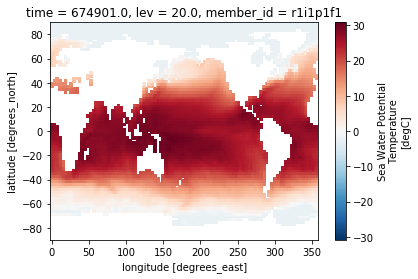

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)


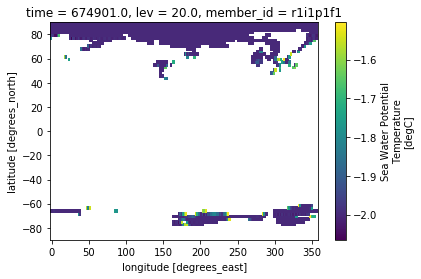

In [21]:
ds = dset_dict[i].thetao.isel(time=0,lev=0)
ds.plot(); plt.show(); plt.close()
ds.where(ds<-1.5).plot(); plt.show(); plt.close()

In [22]:
dset_dict[i].latitude.where(dset_dict[i].thetao.isel(time=0,lev=0)<-1.5)

<xarray.DataArray 'latitude' (latitude: 80, member_id: 1, longitude: 192)>
dask.array<where, shape=(80, 1, 192), dtype=float64, chunksize=(80, 1, 192), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -88.63 -86.13 -83.88 ... 83.88 86.13 88.63
  * longitude  (longitude) float64 -0.9375 0.9375 2.812 ... 353.4 355.3 357.2
    time       float64 6.749e+05
    lev        float64 20.0
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    axis:           Y
    bounds:         lat_bnds
    cell_methods:   time: point
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north

In [ ]:
ds.where(ds<0.)
ds.lev.where(ds.dens_diff.min(['lev']))